# Semisupervised Learning
The field of semisupervised learning blends the benefits of both supervised and unsupervised learning, taking advantage of the few labels that are available to uncover structure in a dataset and help label the rest. 

## Data Preperation

In [1]:
import numpy as np
import pandas as pd
# import modin.pandas as pd
import os, time, re, pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score

import lightgbm as lgb
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [17]:
import gc

For us to tackle this as a semi-supervised learning problem. We must drop 90% of our labeled data (fraudulent) so we can work with partially labelled data.

In [18]:
# Loading data
file = './datasets/credit_card_data/credit_card_data.csv'
data = pd.read_csv(file)

In [20]:
# Dropping 90% of fraudulent data
mask=data['Class']==1
data_to_drop = data.copy()[mask].sample(frac=0.90, random_state=2018)

# indexes
data_to_drop.index

# Dropping all those values
data.drop(data_to_drop.index, inplace=True)

# deleting data_to_drop
del data_to_drop
gc.collect()

31

In [23]:
# Checking if we dropped values
data['Class'].value_counts()

0    284315
1        49
Name: Class, dtype: int64

In [24]:
# Creating our two datasets, feature set, label set
data_X = data.copy().drop(['Class', 'Time'], axis=1)
data_Y = data['Class'].copy()

In [25]:
# Scaling our data
features_to_scale = data_X.columns

sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)

data_X.loc[:,features_to_scale] = sX.fit_transform(data_X[features_to_scale])

In [26]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=2018, stratify=data_Y)

In [30]:
# Helper functions
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

```precision_analysis``` is a function that will help us assess the precision of our models at a certain level of recall. 

We will determine what the model's precision is to catch 75% of the fraudulent credit card transactions in the test set. 

The higher the precision, the better the model. We want to catch 75% of the fraud with as high of a precision as possible. 

In [31]:
def precision_analysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df['trueLabel'].sum() # double check
    
    i = 0
    j = 0
    
    while i < threshold_value+1:
        if df.iloc[j]['trueLabel']==1:
            i += 1
        j += 1
    return df, i/j

## Supervised Model
To place an initial benchmark we will see how well a supervised model and a unsupervised model do in isolation. 

We will strt with a supervised learning solution based on light gradient boosting. We will use k-fold cross-validation to create five folds

In [33]:
# K-folds
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

# lightgb parameters
params_lightGB = {
    "task": "train",
    "application": "binary",
    "num_class": 1,
    "boosting": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "metric_freq": 50,
    "is_training_metric": False,
    "max_depth": 4,
    "num_leaves": 31,
    "learning_rate": 0.01,
    "feature_fraction": 1.0,
    "bagging_fraction": 1.0,
    "bagging_freq": 0,
    "bagging_seed": 2018,
    "verbose": 0,
    "num_threads": 16
}

In [34]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00258474
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00255913
[3]	valid_0's binary_logloss: 0.00255563
[4]	valid_0's binary_logloss: 0.00255362
[5]	valid_0's binary_logloss: 0.00257022
[6]	valid_0's binary_logloss: 0.00244255
[7]	valid_0's binary_logloss: 0.00244027
[8]	valid_0's binary_logloss: 0.00243816
[9]	valid_0's binary_logloss: 0.0024537
[10]	valid_0's binary_logloss: 0.00269891
[11]	valid_0's binary_logloss: 0.00269647
[12]	valid_0's binary_logloss: 0.00269372
[13]	valid_0's binary_logloss: 0.0026934
[14]	valid_0's binary_logloss: 0.00269349
[15]	valid_0's binary_logloss: 0.00269358
[16]	valid_0's binary_logloss: 0.00269364
[17]	valid_0's binary_logloss: 0.00269322
[18]	valid_0's binary_logloss: 0.00269361
[19]	valid_0's binary_logloss: 0.00269351
[20]	valid_0's binary_logloss: 0.00269375
[21]	valid_0's binary_logloss: 0.00269347
[22]	valid_0's binary_logloss: 0.00268931
[23]	valid_0's binary_lo

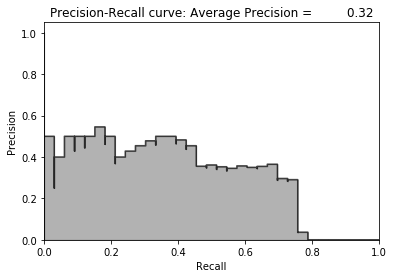

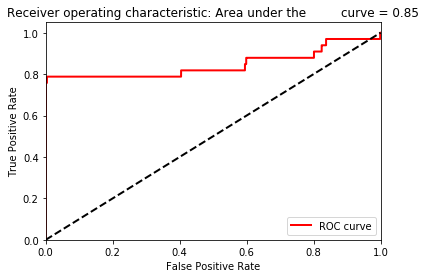

In [37]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

## Unsupervised Model
We will build a sparse two-layer overcomplete autoencoder with a linear activation function. 

We will have 40 nodes in the hidden layer and a dropout of 2%.

We will adjust our training set by oversampling the number of fraudulent cases we have. *oversampling* is a technique used to adjust the class distribution in a given dataset. We want to add more fraudulent cases to our dataset so that the autoencoder we train has an easier time seperating the normal/nonfraudulent transactions from the abnormal/fraudulent ones. 

We will take our 33 faudulent cases, duplicate these 100 times, and then append them to the training set.

We will also keep copies of the nonoversampled training set so we can use them for the rest of our machine learning pipeline. 

In [38]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()

X_train_oversampled = X_train_oversampled.append([X_train_oversampled[y_train==1]]*oversample_multiplier, ignore_index=False)

y_train_oversampled = y_train_oversampled.append([y_train_oversampled[y_train==1]]*oversample_multiplier, ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [41]:
y_train.value_counts()

0    190490
1      3333
Name: Class, dtype: int64

In [48]:
# Training the autoencoder
model = Sequential()

model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29, name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

model.compile(
    optimizer='adam',
    loss="mean_squared_error",
    metrics=['accuracy']
)

num_epochs = 5
batch_size = 32

# training
history = model.fit(
    x=X_train,
    y=X_train,
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.20,
    verbose=1
)

Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 6s 40us/step - loss: 0.1281 - acc: 0.8755 - val_loss: 0.0890 - val_acc: 0.9661
Epoch 2/5
155058/155058 [==============================] - 6s 39us/step - loss: 0.0559 - acc: 0.9248 - val_loss: 0.1723 - val_acc: 0.9406
Epoch 3/5
155058/155058 [==============================] - 7s 44us/step - loss: 0.0461 - acc: 0.9249 - val_loss: 0.5083 - val_acc: 0.9171
Epoch 4/5
155058/155058 [==============================] - 7s 48us/step - loss: 0.0425 - acc: 0.9227 - val_loss: 0.0995 - val_acc: 0.9616
Epoch 5/5
155058/155058 [==============================] - 8s 53us/step - loss: 0.0388 - acc: 0.9220 - val_loss: 0.1284 - val_acc: 0.9698


93841/93841 [==============================] - 1s 8us/step


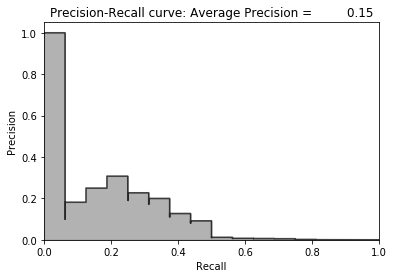

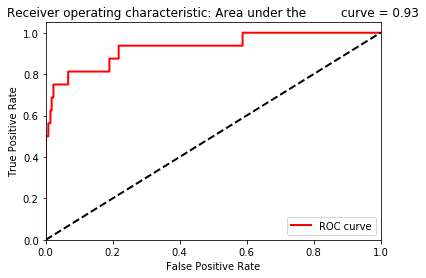

In [49]:
# Evaluating 
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_prevision = plotResults(y_test, anomalyScoresAE, True)

# Semisupervised Model
Let's take the representation learned by the autoencoder (hidden layer), combine it with the original training set, and feed this into the gradient boosting algorithm 

So we will essentially be feeding the output from our unsupervised learning model onto our supervised learning model. 

The initial input will go into our autoencoder, we will call .predict on our autoencoder which produces a reconstruction of the raw input. 

The output of the autoencoder will be added onto the original data. 

The original data contains 29 features, whereas the newly combined data will contain 69 features. 

This will add more features to our dataset. 

This reconstructed data will be feed into our supervised learning model which is XGBoost (light)

In [56]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

intermediate_output_train = intermediate_layer_model.predict(X_train_original)

intermediate_output_test = intermediate_layer_model.predict(X_test_original)

In [58]:
# Storing the output into DF and combining them with the original training set
intermediate_output_train_DF = pd.DataFrame(data=intermediate_output_train, index=X_train_original.index)

intermediate_output_test_DF = pd.DataFrame(data=intermediate_output_test, index=X_test_original.index)

# combine
X_train = X_train_original.merge(intermediate_output_train_DF, left_index=True, right_index=True)
X_test = X_test_original.merge(intermediate_output_test_DF, left_index=True, right_index=True)

y_train = y_train_original.copy()

In [59]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,30,31,32,33,34,35,36,37,38,39
144537,-0.998013,1.214053,-0.208159,-0.053610,-0.707806,-0.698522,-0.174056,1.053884,-0.716236,-0.183657,...,0.089569,0.002710,0.102723,-0.131834,0.155969,-0.174049,-0.097841,-0.006485,0.215420,0.065126
145937,-0.203605,0.127881,0.090052,-1.194883,1.772244,3.062218,-0.266490,0.988854,0.367479,-0.933051,...,-0.180191,-0.258218,-0.021293,-0.299133,0.055346,0.050295,0.357337,0.100884,0.200280,-0.303481
234874,-0.201804,-3.137372,-1.501014,0.010362,-1.111299,1.234106,0.372788,0.115978,0.118297,-0.067225,...,0.590783,-0.363525,-0.199411,-0.036984,0.273366,-0.094188,-0.054566,0.517554,-0.121171,-0.318498
266054,1.095807,-0.481541,-0.815939,-0.606124,-0.486979,-0.926784,-0.271082,-0.360761,-0.543527,0.762455,...,-0.059013,0.179542,-0.244484,0.057253,-0.110715,-0.059421,0.104439,0.063767,0.049536,-0.140517
172417,-0.079991,0.317694,0.585147,-0.485684,0.152971,0.028626,0.499641,-0.218595,0.834722,-0.309597,...,0.098392,-0.315550,-0.190693,-0.214539,-0.008675,0.460683,0.110121,-0.123225,-0.064013,-0.063725


In [61]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00282468
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.0046451
[3]	valid_0's binary_logloss: 0.00172818
[4]	valid_0's binary_logloss: 0.00171513
[5]	valid_0's binary_logloss: 0.00170569
[6]	valid_0's binary_logloss: 0.00169502
[7]	valid_0's binary_logloss: 0.00168374
[8]	valid_0's binary_logloss: 0.00167745
[9]	valid_0's binary_logloss: 0.00166278
[10]	valid_0's binary_logloss: 0.00164809
[11]	valid_0's binary_logloss: 0.00163743
[12]	valid_0's binary_logloss: 0.00162608
[13]	valid_0's binary_logloss: 0.00161578
[14]	valid_0's binary_logloss: 0.00160742
[15]	valid_0's binary_logloss: 0.00159877
[16]	valid_0's binary_logloss: 0.00158963
[17]	valid_0's binary_logloss: 0.00158114
[18]	valid_0's binary_logloss: 0.00157352
[19]	valid_0's binary_logloss: 0.00156613
[20]	valid_0's binary_logloss: 0.00155917
[21]	valid_0's binary_logloss: 0.00155262
[22]	valid_0's binary_logloss: 0.00154634
[23]	valid_0's binary_l

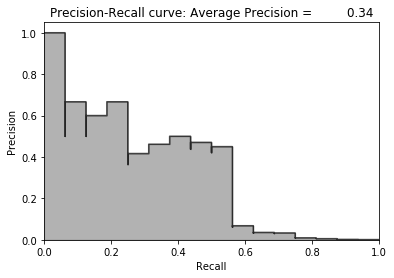

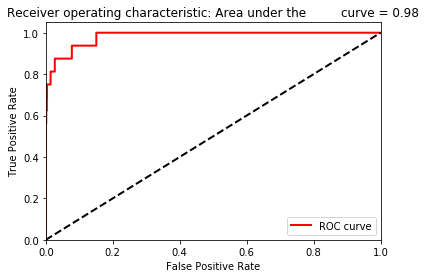

In [62]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

## Power of Supervised and Unsupervised Models
The combination of supervised with unsupervised learning can yield powerfull results.

In our experiments, they have shown to perfrom better when combined rather than alone. 

**gradient boosting** is also a great tool to analyze 'most import features' which we will do below

In [63]:
features_importance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns, columns=['Feature_Importance'])

features_importance = features_importance/features_importance.sum()

features_importance.sort_values(by='Feature_Importance', ascending=False, inplace=True)

In [65]:
features_importance.head(10)

,Feature_Importance
V10,0.083750
V14,0.072511
V4,0.068958
17,0.063085
11,0.052135
10,0.051773
V26,0.047422
V23,0.037488
V24,0.031470
22,0.030890
